In [21]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from math import *
import time
import copy
import random
from matplotlib import animation
from IPython.display import HTML

In [22]:
### RESETTING IMAGE RESOLUTION

umpp = 0.91 # um per pixel
time_i = 0 # initial time frame
time_f = 23 # final time frame
path = "Data/nov3_pad3_YFP/monoculture_nov3_pad3_22hr-02_s2t" # file name until timestamp
fc = "Cy3" # fluorescent channel name

nump = 50 # number of pixels to combine when resizing
dx = nump*umpp

dthr = 1 # time interval between frames in hr

# Import images

Phase = []
FC = []

t = time_i+1

im = np.array(Image.open(path+str(t).zfill(2)+".jpg").convert('L'))
Ly = len(im)
Lx = len(im[0])

Ly_new = int(Ly/nump)
Lx_new = int(Lx/nump)

size = Lx_new, Ly_new

def resolve_down(im, factor):
    Lx, Ly = im.size
    
    LR_off = Lx%factor
    L_off = int(LR_off/2)
    R_off = Lx-LR_off+L_off
    TB_off = Ly%factor
    T_off = int(TB_off/2)
    B_off = Ly-TB_off+T_off
    
    im1 = np.array(im.crop((L_off, T_off, R_off, B_off)))
    
    new = []
    for a in im1:
        b = a.reshape(-1, factor).mean(axis=1)
        new.append(b)
    new = np.array(new).T
    neww = []
    for a in new:
        b = a.reshape(-1, factor).mean(axis=1)
        neww.append(b)
    newww = np.array(neww).T
    
    return newww

while t<time_f:
    imp = Image.open(path+str(t).zfill(2)+"_Phase.jpg").convert('L')
    imp_resized = resolve_down(imp, nump)
    #imp_resized = np.array(imp.resize(size, Image.ANTIALIAS)).astype(np.float32)/
    imf = Image.open(path+str(t).zfill(2)+"_{}.jpg".format(fc)).convert('L')
    imf_resized = resolve_down(imf, nump)
    #imf_resized = np.array(imf.resize(size, Image.ANTIALIAS)).astype(np.float32)
    
    Phase.append(imp_resized)
    FC.append(imf_resized)
    t+=1
    
Phase = np.array(Phase)
FC = np.array(FC)

In [13]:
## STARTING MODEL PARAMETERS and step size bounds

# Cell

mu = 0.0000489        # max growth rate of strain 1 (in 1/sec)
step_mu = 0.05/3600

Rhf = 291              # cell density for half pressure (in pixel intensity)
step_Rhf = 5

Qhf = 77              # cell density for half pressure (in pixel intensity)
step_Qhf = 5

Phf = 173              # cell density for half acceptance (in pixel intensity)
step_Phf = 5

Y = 53               # biomass yield (in pixel intensity per unit S0)
step_Y = 5

# Glucose
log10Ks = -1.93          # rate of nutrient consumption by Monod kinetics (in unit log10S0)
step_log10Ks = 0.1 

# Diffusion
DC = 3178             # spreading coefficient of cells (in um^2)
step_DC = 50

DS = 435              # diffusion coefficient of glucose (in um^2/sec)
step_DS = 50

# Initial condition
S0 = 1                # glucose concentration in feed medium

Parameters = [mu, Qhf, Phf, Y, log10Ks, DC, DS]
steps = [step_mu, step_Qhf, step_Phf, step_Y, step_log10Ks, step_DC, step_DS]
idx_ex = [4] # index of parameter that need not be non-negative

In [14]:
## GRADIENT FUNCTIONS

def grad_vec_field(series, t, Lx, Ly, dx):

    xr = np.arange(0, Ly*dx, dx)
    yr = np.arange(0, Lx*dx, dx)

    # Create grid corresponding to xr and yr arrays
    xx, yy = np.meshgrid (xr, yr, indexing = 'ij')

    zz1 = series[t+1]
    gradx1, grady1 = np.gradient(zz1, dx, dx)

    zz0 = series[t]
    gradx0, grady0 = np.gradient (zz0, dx, dx)
    
    return(xx, yy, gradx1-gradx0, grady1-grady0)

def plot_vec_field(series, t, Lx, Ly, dx):
    
    xx, yy, Dx, Dy = grad_vec_field(series, t, Lx, Ly, dx)

    fig = plt.figure(constrained_layout=True, figsize=(15,8))
    axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[2, 1]})
    
    TB = axs['TopRight'].imshow(-Dx, cmap='coolwarm')
    axs['TopRight'].set_title('Y component of ascent rate')
    fig.colorbar(TB, ax=axs['TopRight'])
    
    LR = axs['BottomRight'].imshow(Dy, cmap='coolwarm')
    axs['BottomRight'].set_title('X component of ascent rate')
    fig.colorbar(LR, ax=axs['BottomRight'])
    
    skip = (slice(None, None, 2), slice(None, None, 2))

    axs['Left'].quiver(yy[skip], np.flip(xx)[skip], Dy[skip] , -Dx[skip],
                      color='black', headwidth=5, scale=1, headlength=5)

## MODEL FUNCTIONS

def nbr_sum(M):
    """Get the discrete Laplacian of matrix M"""
    L = np.roll(M, (0,-1), (0,1)) # right neighbor
    L += np.roll(M, (0,+1), (0,1)) # left neighbor
    L += np.roll(M, (-1,0), (0,1)) # top neighbor
    L += np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    return L

def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += nbr_sum(M)
    
    return L

def divide(M1,M2):
    """To divide two numpy arrays M1/M2 element-wise and avoide division by zero"""
    f = np.divide(M1, M2, out=np.zeros_like(M1), where=M2!=0)
    return f

def update(C, S, Parameters):
    
    k, mu, Rhf, Qhf, Phf, Y, Ks, DC, DS = tuple(Parameters)
    
    R = C/(Rhf+C)
    Q = C/(Qhf+C)
    P = Phf/(Phf+C)
    
    Sdiff = res*DS*discrete_laplacian(S) - dt*mu*C*divide(S,Y*(Ks+S))
    Cdiff = dt*mu*(1-R)*C*S/(Ks+S) + res*DC*mu*(P*nbr_sum(C*Q*S/(Ks+S)) - Q*C*S*nbr_sum(P)/(Ks+S))
    
    C += Cdiff
    S += Sdiff
    # Remove negative values
    S[S < 0] = 0 
    
    # Reflecting boundaries
    
    C[0,:], S[0,:] = C[1,:], S[1,:]          # top
    C[-1,:], S[-1,:] = C[-2,:], S[-2,:] # bottom
    C[:,0], S[:,0] = C[:,1], S[:,1]         # left
    C[:,-1], S[:,-1] = C[:,-2], S[:,-2]  # right
                            
    return C, S

def get_error(Phase, FC, Parameters):
    
    k = Parameters[0]
    # Initialize
    C = copy.deepcopy(FC[0])*k
    C -= threshold
    C[C<0]=0
    S = np.ones((Ly_new,Lx_new))

    # Simulate

    update_every = dthr*3600 # number of time steps after which data is stored
    C_time = []
    S_time = []

    start = time.time()

    for tt in range(T):
        if tt%update_every == 0:
            C_time.append(C.copy())
            S_time.append(S.copy())
        C, S = update(C, S, Parameters)

    stop = time.time()

    error_int = 0
    error_grad = 0

    t = time_i

    while t<time_f-2:
        xx, yy, DxO, DyO = grad_vec_field(Phase, t, Lx_new, Ly_new, dx)
        xx, yy, DxP, DyP = grad_vec_field(C_time, t, Lx_new, Ly_new, dx)
    
        error_int += np.sum((C_time[t]-Phase[t])**2)
        error_grad += np.sum((DxP-DxO)**2 + (DyP-DyO)**2)
        t+=1

    return(error_int, error_grad)

def cap_par(Parameters, idx_ex):
    i = 0
    for par in Parameters:
        if i in idx_ex:
            continue
        else:
            Parameters[i] = max(0, par)
        i+=1
    return(Parameters)

In [15]:
### SIMULATED ANNEALING PARAMETERS

# coefficient of error formula
lam = 10**3

# Number of iterations of simated annealing
an_steps = 1000

# Initial temperature
maxTemp = 5*10**-4

### SIMULATION PARAMETERS
# threshold
threshold = 1 # number to subtract from all pixels of the image used as initial condition for simulation

# Time Resolution in sec
dt = 1
# Time steps
T = int((time_f-1)*dthr*3600)

res = dt/dx**2 

print("Simulation time is", dt*T, "seconds \n dt =", dt, "seconds")
print("dt / dx^2 = ", res)

Simulation time is 79200 seconds 
 dt = 1 seconds
dt / dx^2 =  0.0004830334500664171


In [89]:
iter = 0
Parameters = np.array(Parameters)
errors = []
Temps = []
Parameters_dat = []

E1, E2 = get_error(Phase, FC, Parameters)
current_error = sqrt(E1 + lam*E2)

while iter < an_steps:
    
    Temp = maxTemp/(iter+1)
    
    new_Parameters = Parameters + np.array(random.choices([-1,0,1],k=len(Parameters)))*np.array(steps)
    #new_Parameters = cap_par(new_Parameters, idx_ex)
    print(new_Parameters)
    
    #if new_Parameters.tolist() in Parameters_dat:
    #    new_error = errors[Parameters_dat.index(new_Parameters.tolist())]
    #else:
    #    new_error, n = get_error(Phase, FC, new_Parameters)
    E1, E2 = get_error(Phase, FC, new_Parameters)
    new_error = sqrt(E1 + lam*E2)
    
    Derror = new_error - current_error
    
    if Derror <= 0:
        Parameters = new_Parameters
        current_error = new_error
        print('accepted', iter)
    else:
        metropolis = 2.7183**(-Derror/Temp)
        rand = random.uniform(0,1)
        if rand < metropolis:
            Parameters = new_Parameters
            current_error = new_error
            print('accepted', iter)
        else:
            print('declined', iter)
    
    errors.append(current_error)
    Temps.append(Temp)
    Parameters_dat.append(Parameters.tolist())
    
    iter +=1

[ 1.38888889e-04  1.45000000e+02  1.55000000e+02  1.65000000e+02
 -2.00000000e+00  1.15000000e+03  5.50000000e+02]


C:\Users\sulta\anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in multiply
C:\Users\sulta\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in multiply
C:\Users\sulta\anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sulta\anaconda3\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in multiply
C:\Users\sulta\anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in multiply
C:\Users\sulta\anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in add
C:\Users\sulta\anaconda3\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide
C:\Users\sulta\anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide


declined 0
[ 1.38888889e-04  1.45000000e+02  1.50000000e+02  1.65000000e+02
 -2.10000000e+00  1.15000000e+03  4.50000000e+02]
declined 1
[ 1.11111111e-04  1.55000000e+02  1.50000000e+02  1.60000000e+02
 -2.10000000e+00  1.25000000e+03  5.50000000e+02]
declined 2
[ 1.25e-04  1.45e+02  1.45e+02  1.60e+02 -1.90e+00  1.15e+03  4.50e+02]
accepted 3
[ 1.38888889e-04  1.45000000e+02  1.50000000e+02  1.55000000e+02
 -2.00000000e+00  1.15000000e+03  5.00000000e+02]
declined 4
[ 1.25e-04  1.45e+02  1.40e+02  1.65e+02 -1.80e+00  1.20e+03  4.50e+02]
declined 5
[ 1.38888889e-04  1.40000000e+02  1.40000000e+02  1.60000000e+02
 -2.00000000e+00  1.20000000e+03  4.50000000e+02]
declined 6
[ 1.11111111e-04  1.50000000e+02  1.40000000e+02  1.65000000e+02
 -1.80000000e+00  1.10000000e+03  4.00000000e+02]
accepted 7
[ 9.72222222e-05  1.45000000e+02  1.45000000e+02  1.70000000e+02
 -1.70000000e+00  1.10000000e+03  4.00000000e+02]
accepted 8
[ 9.72222222e-05  1.40000000e+02  1.45000000e+02  1.70000000e+02
 -

declined 66
[ 8.33333333e-05  1.35000000e+02  1.55000000e+02  1.60000000e+02
 -1.70000000e+00  1.20000000e+03  4.00000000e+02]
declined 67
[ 8.33333333e-05  1.40000000e+02  1.55000000e+02  1.65000000e+02
 -1.80000000e+00  1.20000000e+03  4.50000000e+02]
declined 68
[ 5.55555556e-05  1.40000000e+02  1.55000000e+02  1.65000000e+02
 -1.80000000e+00  1.20000000e+03  4.50000000e+02]
declined 69
[ 5.55555556e-05  1.30000000e+02  1.50000000e+02  1.60000000e+02
 -1.80000000e+00  1.10000000e+03  3.50000000e+02]
declined 70
[ 6.94444444e-05  1.40000000e+02  1.55000000e+02  1.60000000e+02
 -1.70000000e+00  1.20000000e+03  3.50000000e+02]
declined 71
[ 6.94444444e-05  1.40000000e+02  1.55000000e+02  1.70000000e+02
 -1.80000000e+00  1.15000000e+03  4.50000000e+02]
declined 72
[ 5.55555556e-05  1.30000000e+02  1.60000000e+02  1.60000000e+02
 -1.90000000e+00  1.10000000e+03  3.50000000e+02]
declined 73
[ 6.94444444e-05  1.35000000e+02  1.55000000e+02  1.65000000e+02
 -1.80000000e+00  1.15000000e+03  

declined 131
[ 6.94444444e-05  1.10000000e+02  1.85000000e+02  1.70000000e+02
 -2.10000000e+00  1.10000000e+03  2.50000000e+02]
declined 132
[ 6.94444444e-05  1.05000000e+02  1.75000000e+02  1.70000000e+02
 -2.10000000e+00  1.10000000e+03  2.50000000e+02]
declined 133
[ 6.94444444e-05  1.15000000e+02  1.80000000e+02  1.60000000e+02
 -2.30000000e+00  1.10000000e+03  3.50000000e+02]
declined 134
[ 6.94444444e-05  1.05000000e+02  1.85000000e+02  1.70000000e+02
 -2.10000000e+00  1.15000000e+03  2.50000000e+02]
declined 135
[ 5.55555556e-05  1.15000000e+02  1.85000000e+02  1.70000000e+02
 -2.20000000e+00  1.15000000e+03  2.50000000e+02]
declined 136
[ 5.55555556e-05  1.05000000e+02  1.85000000e+02  1.70000000e+02
 -2.20000000e+00  1.20000000e+03  3.50000000e+02]
declined 137
[ 6.94444444e-05  1.10000000e+02  1.85000000e+02  1.65000000e+02
 -2.30000000e+00  1.15000000e+03  3.50000000e+02]
accepted 138
[ 5.55555556e-05  1.10000000e+02  1.90000000e+02  1.65000000e+02
 -2.40000000e+00  1.100000

declined 196
[ 8.33333333e-05  1.05000000e+02  1.90000000e+02  1.60000000e+02
 -2.60000000e+00  1.25000000e+03  3.00000000e+02]
declined 197
[ 6.94444444e-05  1.05000000e+02  1.90000000e+02  1.55000000e+02
 -2.60000000e+00  1.25000000e+03  3.00000000e+02]
accepted 198
[ 5.55555556e-05  1.10000000e+02  1.90000000e+02  1.60000000e+02
 -2.60000000e+00  1.30000000e+03  3.00000000e+02]
declined 199
[ 6.94444444e-05  1.00000000e+02  1.85000000e+02  1.55000000e+02
 -2.70000000e+00  1.20000000e+03  2.50000000e+02]
declined 200
[ 6.94444444e-05  1.00000000e+02  1.85000000e+02  1.50000000e+02
 -2.50000000e+00  1.30000000e+03  2.50000000e+02]
declined 201
[ 5.55555556e-05  1.10000000e+02  1.95000000e+02  1.55000000e+02
 -2.60000000e+00  1.25000000e+03  3.00000000e+02]
declined 202
[ 5.55555556e-05  1.10000000e+02  1.90000000e+02  1.55000000e+02
 -2.50000000e+00  1.20000000e+03  2.50000000e+02]
declined 203
[ 5.55555556e-05  1.10000000e+02  1.85000000e+02  1.60000000e+02
 -2.60000000e+00  1.300000

declined 261
[ 8.33333333e-05  1.05000000e+02  2.00000000e+02  1.45000000e+02
 -2.80000000e+00  1.50000000e+03  3.00000000e+02]
declined 262
[ 6.94444444e-05  1.15000000e+02  2.05000000e+02  1.50000000e+02
 -2.70000000e+00  1.50000000e+03  3.50000000e+02]
accepted 263
[ 5.55555556e-05  1.15000000e+02  2.05000000e+02  1.55000000e+02
 -2.70000000e+00  1.50000000e+03  3.50000000e+02]
declined 264
[ 5.55555556e-05  1.15000000e+02  2.10000000e+02  1.45000000e+02
 -2.80000000e+00  1.50000000e+03  3.00000000e+02]
declined 265
[ 5.55555556e-05  1.15000000e+02  2.05000000e+02  1.50000000e+02
 -2.70000000e+00  1.55000000e+03  4.00000000e+02]
declined 266
[ 5.55555556e-05  1.10000000e+02  2.00000000e+02  1.50000000e+02
 -2.80000000e+00  1.45000000e+03  4.00000000e+02]
declined 267
[ 6.94444444e-05  1.15000000e+02  2.05000000e+02  1.55000000e+02
 -2.80000000e+00  1.45000000e+03  3.00000000e+02]
declined 268
[ 5.55555556e-05  1.10000000e+02  2.10000000e+02  1.55000000e+02
 -2.80000000e+00  1.500000

declined 326
[ 6.94444444e-05  1.15000000e+02  1.90000000e+02  1.55000000e+02
 -2.40000000e+00  1.65000000e+03  2.50000000e+02]
declined 327
[ 6.94444444e-05  1.20000000e+02  1.90000000e+02  1.45000000e+02
 -2.40000000e+00  1.75000000e+03  2.50000000e+02]
accepted 328
[ 8.33333333e-05  1.20000000e+02  1.85000000e+02  1.45000000e+02
 -2.40000000e+00  1.70000000e+03  2.50000000e+02]
declined 329
[ 6.94444444e-05  1.15000000e+02  1.90000000e+02  1.45000000e+02
 -2.40000000e+00  1.80000000e+03  2.00000000e+02]
accepted 330
[ 5.55555556e-05  1.20000000e+02  1.95000000e+02  1.45000000e+02
 -2.40000000e+00  1.80000000e+03  1.50000000e+02]
declined 331
[ 5.55555556e-05  1.20000000e+02  1.90000000e+02  1.45000000e+02
 -2.30000000e+00  1.75000000e+03  2.00000000e+02]
declined 332
[ 8.33333333e-05  1.10000000e+02  1.85000000e+02  1.45000000e+02
 -2.50000000e+00  1.80000000e+03  1.50000000e+02]
declined 333
[ 5.55555556e-05  1.15000000e+02  1.90000000e+02  1.45000000e+02
 -2.40000000e+00  1.850000

declined 391
[ 6.94444444e-05  1.20000000e+02  1.75000000e+02  1.45000000e+02
 -2.50000000e+00  1.95000000e+03  1.00000000e+02]
accepted 392
[ 8.33333333e-05  1.25000000e+02  1.70000000e+02  1.40000000e+02
 -2.40000000e+00  2.00000000e+03  5.00000000e+01]
declined 393
[ 5.55555556e-05  1.20000000e+02  1.80000000e+02  1.45000000e+02
 -2.40000000e+00  1.95000000e+03  1.50000000e+02]
declined 394
[ 8.33333333e-05  1.25000000e+02  1.70000000e+02  1.45000000e+02
 -2.40000000e+00  1.90000000e+03  1.00000000e+02]
declined 395
[ 6.94444444e-05  1.20000000e+02  1.75000000e+02  1.45000000e+02
 -2.60000000e+00  1.90000000e+03  1.50000000e+02]
declined 396
[ 5.55555556e-05  1.15000000e+02  1.75000000e+02  1.45000000e+02
 -2.50000000e+00  2.00000000e+03  1.00000000e+02]
declined 397
[ 6.94444444e-05  1.15000000e+02  1.75000000e+02  1.40000000e+02
 -2.50000000e+00  2.00000000e+03  1.50000000e+02]
declined 398
[ 6.94444444e-05  1.15000000e+02  1.75000000e+02  1.40000000e+02
 -2.40000000e+00  1.900000

declined 456
[ 5.55555556e-05  1.25000000e+02  1.95000000e+02  1.35000000e+02
 -2.80000000e+00  2.10000000e+03  1.00000000e+02]
declined 457
[ 5.55555556e-05  1.20000000e+02  1.90000000e+02  1.40000000e+02
 -2.90000000e+00  2.10000000e+03  5.00000000e+01]
declined 458
[ 5.55555556e-05  1.25000000e+02  1.85000000e+02  1.35000000e+02
 -2.90000000e+00  2.10000000e+03  1.00000000e+02]
declined 459
[ 5.55555556e-05  1.20000000e+02  1.95000000e+02  1.40000000e+02
 -2.90000000e+00  2.10000000e+03  1.00000000e+02]
declined 460
[ 5.55555556e-05  1.25000000e+02  1.85000000e+02  1.45000000e+02
 -3.00000000e+00  2.05000000e+03  1.50000000e+02]
declined 461
[ 5.55555556e-05  1.15000000e+02  1.85000000e+02  1.40000000e+02
 -3.00000000e+00  2.15000000e+03  1.00000000e+02]
declined 462
[ 6.94444444e-05  1.20000000e+02  1.85000000e+02  1.40000000e+02
 -2.80000000e+00  2.05000000e+03  1.00000000e+02]
declined 463
[ 8.33333333e-05  1.20000000e+02  1.90000000e+02  1.45000000e+02
 -2.80000000e+00  2.150000

declined 521
[ 5.55555556e-05  1.15000000e+02  1.70000000e+02  1.20000000e+02
 -3.00000000e+00  2.10000000e+03  1.50000000e+02]
declined 522
[ 8.33333333e-05  1.25000000e+02  1.75000000e+02  1.25000000e+02
 -3.20000000e+00  2.15000000e+03  2.50000000e+02]
declined 523
[ 6.94444444e-05  1.20000000e+02  1.75000000e+02  1.30000000e+02
 -3.20000000e+00  2.15000000e+03  2.00000000e+02]
accepted 524
[ 6.94444444e-05  1.20000000e+02  1.70000000e+02  1.25000000e+02
 -3.30000000e+00  2.20000000e+03  1.50000000e+02]
accepted 525
[ 5.55555556e-05  1.25000000e+02  1.75000000e+02  1.20000000e+02
 -3.40000000e+00  2.15000000e+03  1.50000000e+02]
declined 526
[ 5.55555556e-05  1.20000000e+02  1.75000000e+02  1.30000000e+02
 -3.40000000e+00  2.25000000e+03  1.50000000e+02]
declined 527
[ 8.33333333e-05  1.15000000e+02  1.75000000e+02  1.20000000e+02
 -3.30000000e+00  2.25000000e+03  1.50000000e+02]
declined 528
[ 5.55555556e-05  1.20000000e+02  1.70000000e+02  1.25000000e+02
 -3.30000000e+00  2.250000

declined 586
[ 8.33333333e-05  1.25000000e+02  1.45000000e+02  1.30000000e+02
 -3.50000000e+00  2.30000000e+03  2.50000000e+02]
declined 587
[ 6.94444444e-05  1.25000000e+02  1.35000000e+02  1.30000000e+02
 -3.40000000e+00  2.20000000e+03  3.00000000e+02]
declined 588
[ 6.94444444e-05  1.15000000e+02  1.45000000e+02  1.30000000e+02
 -3.50000000e+00  2.25000000e+03  2.50000000e+02]
declined 589
[ 8.33333333e-05  1.20000000e+02  1.40000000e+02  1.35000000e+02
 -3.50000000e+00  2.25000000e+03  2.50000000e+02]
declined 590
[ 5.55555556e-05  1.25000000e+02  1.40000000e+02  1.40000000e+02
 -3.50000000e+00  2.20000000e+03  2.50000000e+02]
declined 591
[ 5.55555556e-05  1.15000000e+02  1.35000000e+02  1.35000000e+02
 -3.50000000e+00  2.25000000e+03  3.00000000e+02]
declined 592
[ 6.94444444e-05  1.15000000e+02  1.45000000e+02  1.40000000e+02
 -3.50000000e+00  2.25000000e+03  3.00000000e+02]
declined 593
[ 6.94444444e-05  1.20000000e+02  1.45000000e+02  1.30000000e+02
 -3.50000000e+00  2.300000

declined 651
[ 8.33333333e-05  1.25000000e+02  1.35000000e+02  1.25000000e+02
 -3.50000000e+00  2.15000000e+03  3.50000000e+02]
declined 652
[ 8.33333333e-05  1.20000000e+02  1.40000000e+02  1.25000000e+02
 -3.60000000e+00  2.15000000e+03  3.00000000e+02]
declined 653
[ 6.94444444e-05  1.20000000e+02  1.40000000e+02  1.30000000e+02
 -3.70000000e+00  2.20000000e+03  2.50000000e+02]
accepted 654
[ 6.94444444e-05  1.20000000e+02  1.40000000e+02  1.30000000e+02
 -3.60000000e+00  2.25000000e+03  3.00000000e+02]
declined 655
[ 6.94444444e-05  1.20000000e+02  1.35000000e+02  1.35000000e+02
 -3.70000000e+00  2.15000000e+03  2.50000000e+02]
accepted 656
[ 6.94444444e-05  1.15000000e+02  1.35000000e+02  1.35000000e+02
 -3.60000000e+00  2.10000000e+03  2.50000000e+02]
declined 657
[ 8.33333333e-05  1.25000000e+02  1.35000000e+02  1.30000000e+02
 -3.80000000e+00  2.10000000e+03  3.00000000e+02]
declined 658
[ 8.33333333e-05  1.25000000e+02  1.30000000e+02  1.40000000e+02
 -3.80000000e+00  2.150000

declined 716
[ 6.94444444e-05  1.25000000e+02  1.30000000e+02  1.35000000e+02
 -3.70000000e+00  2.15000000e+03  3.00000000e+02]
declined 717
[ 5.55555556e-05  1.20000000e+02  1.25000000e+02  1.25000000e+02
 -3.60000000e+00  2.10000000e+03  3.00000000e+02]
declined 718
[ 6.94444444e-05  1.20000000e+02  1.20000000e+02  1.30000000e+02
 -3.80000000e+00  2.20000000e+03  3.50000000e+02]
accepted 719
[ 5.55555556e-05  1.15000000e+02  1.25000000e+02  1.30000000e+02
 -3.80000000e+00  2.20000000e+03  4.00000000e+02]
declined 720
[ 6.94444444e-05  1.25000000e+02  1.25000000e+02  1.30000000e+02
 -3.80000000e+00  2.15000000e+03  3.00000000e+02]
declined 721
[ 8.33333333e-05  1.25000000e+02  1.25000000e+02  1.35000000e+02
 -3.70000000e+00  2.15000000e+03  3.00000000e+02]
declined 722
[ 6.94444444e-05  1.25000000e+02  1.20000000e+02  1.30000000e+02
 -3.80000000e+00  2.20000000e+03  3.50000000e+02]
declined 723
[ 6.94444444e-05  1.15000000e+02  1.25000000e+02  1.30000000e+02
 -3.90000000e+00  2.150000

declined 781
[ 6.94444444e-05  1.15000000e+02  9.00000000e+01  1.40000000e+02
 -3.60000000e+00  2.35000000e+03  4.00000000e+02]
declined 782
[ 6.94444444e-05  1.25000000e+02  9.50000000e+01  1.45000000e+02
 -3.50000000e+00  2.25000000e+03  4.00000000e+02]
declined 783
[ 6.94444444e-05  1.15000000e+02  1.00000000e+02  1.45000000e+02
 -3.60000000e+00  2.30000000e+03  4.00000000e+02]
declined 784
[ 8.33333333e-05  1.20000000e+02  9.50000000e+01  1.35000000e+02
 -3.60000000e+00  2.35000000e+03  4.50000000e+02]
declined 785
[ 5.55555556e-05  1.25000000e+02  9.00000000e+01  1.40000000e+02
 -3.50000000e+00  2.35000000e+03  4.00000000e+02]
declined 786
[ 6.94444444e-05  1.20000000e+02  1.00000000e+02  1.40000000e+02
 -3.50000000e+00  2.25000000e+03  4.00000000e+02]
declined 787
[ 5.55555556e-05  1.15000000e+02  9.50000000e+01  1.45000000e+02
 -3.70000000e+00  2.25000000e+03  4.00000000e+02]
declined 788
[ 6.94444444e-05  1.20000000e+02  9.50000000e+01  1.35000000e+02
 -3.70000000e+00  2.300000

declined 846
[ 6.94444444e-05  1.25000000e+02  8.50000000e+01  1.35000000e+02
 -4.00000000e+00  2.25000000e+03  5.00000000e+02]
declined 847
[ 6.94444444e-05  1.15000000e+02  9.00000000e+01  1.35000000e+02
 -3.90000000e+00  2.25000000e+03  5.00000000e+02]
declined 848
[ 5.55555556e-05  1.25000000e+02  8.50000000e+01  1.45000000e+02
 -3.90000000e+00  2.25000000e+03  4.50000000e+02]
declined 849
[ 8.33333333e-05  1.25000000e+02  8.50000000e+01  1.35000000e+02
 -4.00000000e+00  2.30000000e+03  4.50000000e+02]
declined 850
[ 5.55555556e-05  1.20000000e+02  9.00000000e+01  1.40000000e+02
 -3.90000000e+00  2.25000000e+03  4.50000000e+02]
declined 851
[ 5.55555556e-05  1.15000000e+02  9.00000000e+01  1.45000000e+02
 -3.80000000e+00  2.35000000e+03  5.50000000e+02]
declined 852
[ 6.94444444e-05  1.20000000e+02  9.50000000e+01  1.35000000e+02
 -3.90000000e+00  2.30000000e+03  4.50000000e+02]
declined 853
[ 8.33333333e-05  1.15000000e+02  9.50000000e+01  1.45000000e+02
 -4.00000000e+00  2.250000

declined 911
[ 6.94444444e-05  1.25000000e+02  7.50000000e+01  1.30000000e+02
 -4.10000000e+00  2.25000000e+03  5.50000000e+02]
declined 912
[ 8.33333333e-05  1.20000000e+02  8.50000000e+01  1.30000000e+02
 -4.10000000e+00  2.25000000e+03  5.50000000e+02]
declined 913
[ 5.55555556e-05  1.15000000e+02  8.00000000e+01  1.35000000e+02
 -3.90000000e+00  2.25000000e+03  4.50000000e+02]
declined 914
[ 6.94444444e-05  1.25000000e+02  8.50000000e+01  1.30000000e+02
 -4.10000000e+00  2.25000000e+03  4.50000000e+02]
declined 915
[ 8.33333333e-05  1.25000000e+02  7.50000000e+01  1.30000000e+02
 -3.90000000e+00  2.30000000e+03  4.50000000e+02]
declined 916
[ 6.94444444e-05  1.20000000e+02  8.00000000e+01  1.30000000e+02
 -3.90000000e+00  2.35000000e+03  5.00000000e+02]
accepted 917
[ 5.55555556e-05  1.25000000e+02  8.50000000e+01  1.25000000e+02
 -4.00000000e+00  2.30000000e+03  4.50000000e+02]
declined 918
[ 5.55555556e-05  1.20000000e+02  8.00000000e+01  1.35000000e+02
 -3.80000000e+00  2.400000

declined 976
[ 8.33333333e-05  1.20000000e+02  6.50000000e+01  1.30000000e+02
 -4.10000000e+00  2.35000000e+03  4.50000000e+02]
declined 977
[ 6.94444444e-05  1.15000000e+02  7.50000000e+01  1.40000000e+02
 -4.00000000e+00  2.35000000e+03  5.50000000e+02]
declined 978
[ 8.33333333e-05  1.15000000e+02  7.00000000e+01  1.30000000e+02
 -4.00000000e+00  2.40000000e+03  4.50000000e+02]
declined 979
[ 5.55555556e-05  1.20000000e+02  7.50000000e+01  1.35000000e+02
 -4.20000000e+00  2.30000000e+03  5.50000000e+02]
declined 980
[ 8.33333333e-05  1.20000000e+02  7.50000000e+01  1.35000000e+02
 -4.10000000e+00  2.30000000e+03  5.00000000e+02]
declined 981
[ 5.55555556e-05  1.25000000e+02  7.00000000e+01  1.30000000e+02
 -4.10000000e+00  2.40000000e+03  5.50000000e+02]
declined 982
[ 5.55555556e-05  1.25000000e+02  6.50000000e+01  1.30000000e+02
 -4.20000000e+00  2.30000000e+03  4.50000000e+02]
declined 983
[ 8.33333333e-05  1.15000000e+02  6.50000000e+01  1.40000000e+02
 -4.20000000e+00  2.400000

Text(0.5, 0, 'Iteration')

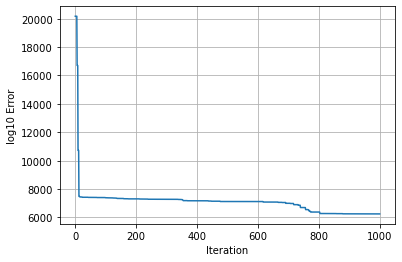

In [254]:
plt.plot(np.sqrt(np.array(errors)))
plt.grid()
plt.ylabel('log10 Error')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

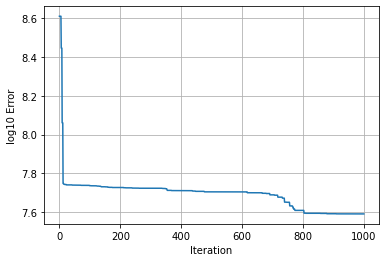

In [184]:
plt.plot(np.log10(np.sqrt(np.array(errors))))
plt.grid()
plt.ylabel('log10 Error')
plt.xlabel('Iteration')

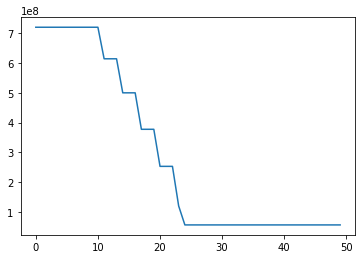

In [135]:
plt.plot(errors)

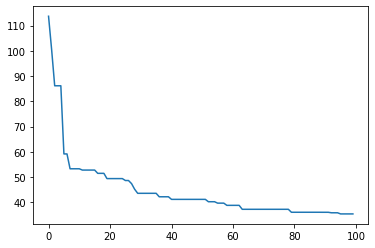

In [166]:
plt.plot(errors)

Text(0.5, 0, 'Iteration')

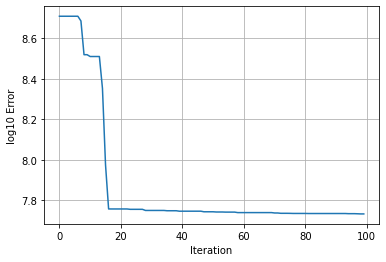

In [148]:
plt.plot(np.log10(np.array(errors)))
plt.grid()
plt.ylabel('log10 Error')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

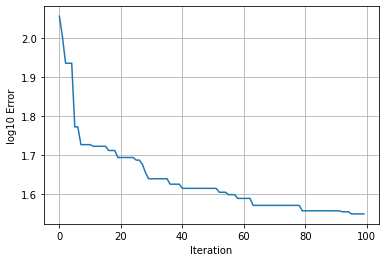

In [167]:
plt.plot(np.log10(np.array(errors)))
plt.grid()
plt.ylabel('log10 Error')
plt.xlabel('Iteration')

In [168]:
P = np.array(Parameters_dat)

Text(0.5, 0, 'Iteration')

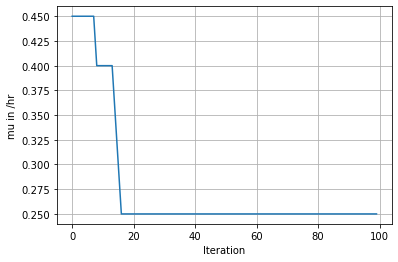

In [153]:
plt.plot(P[:,0]*3600)
plt.grid()
plt.ylabel('mu in /hr')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

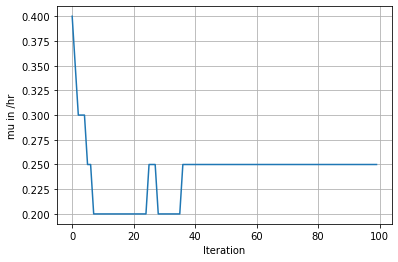

In [169]:
plt.plot(P[:,0]*3600)
plt.grid()
plt.ylabel('mu in /hr')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

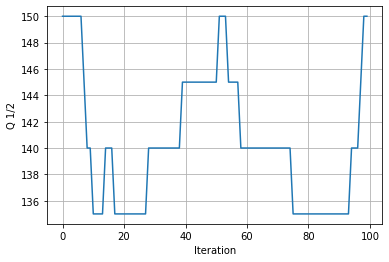

In [156]:
plt.plot(P[:,1])
plt.grid()
plt.ylabel('Q 1/2')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

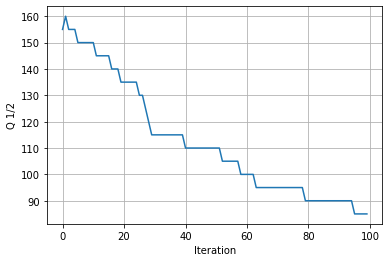

In [170]:
plt.plot(P[:,1])
plt.grid()
plt.ylabel('Q 1/2')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

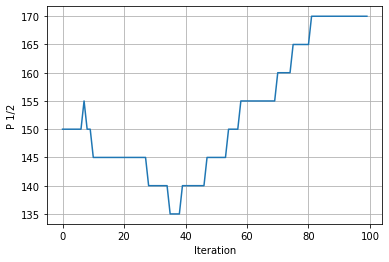

In [157]:
plt.plot(P[:,2])
plt.grid()
plt.ylabel('P 1/2')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

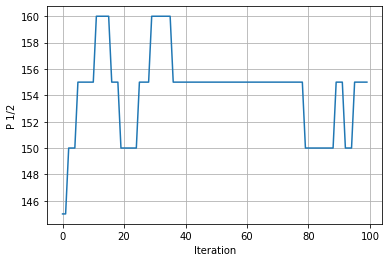

In [171]:
plt.plot(P[:,2])
plt.grid()
plt.ylabel('P 1/2')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

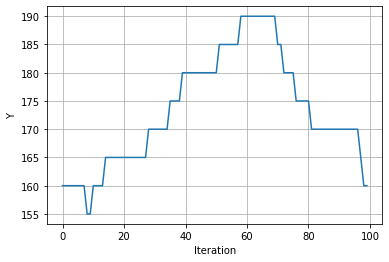

In [158]:
plt.plot(P[:,3])
plt.grid()
plt.ylabel('Y')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

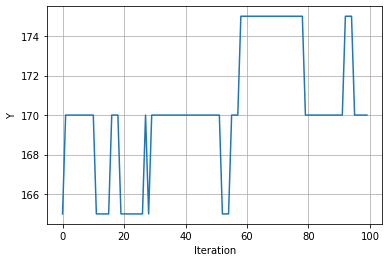

In [172]:
plt.plot(P[:,3])
plt.grid()
plt.ylabel('Y')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

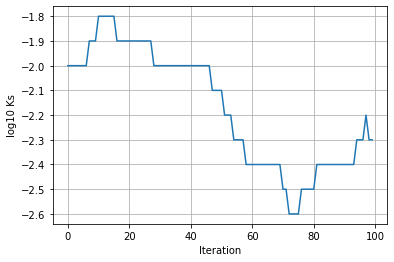

In [159]:
plt.plot(P[:,4])
plt.grid()
plt.ylabel('log10 Ks')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

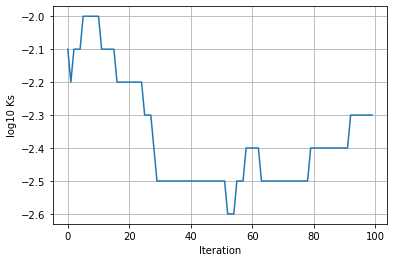

In [173]:
plt.plot(P[:,4])
plt.grid()
plt.ylabel('log10 Ks')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

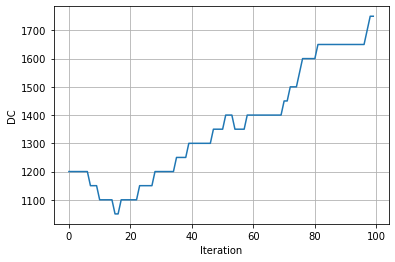

In [160]:
plt.plot(P[:,5])
plt.grid()
plt.ylabel('DC')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

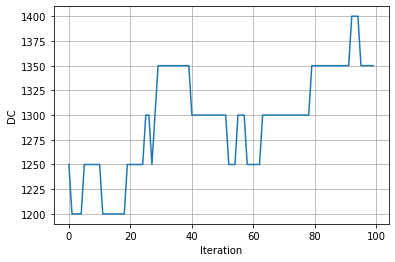

In [174]:
plt.plot(P[:,5])
plt.grid()
plt.ylabel('DC')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

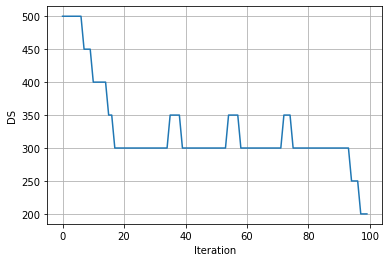

In [161]:
plt.plot(P[:,6])
plt.grid()
plt.ylabel('DS')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

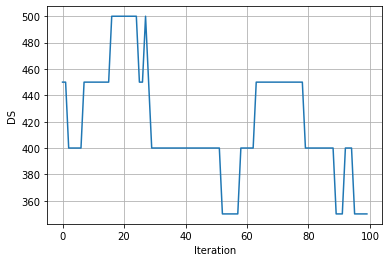

In [175]:
plt.plot(P[:,6])
plt.grid()
plt.ylabel('DS')
plt.xlabel('Iteration')

In [17]:
Parameters = [3, 0.000993, 3024, 7.5, 1491, 9, 0.00109, 202100, 2.25]

In [18]:
# Initialize
C = copy.deepcopy(FC[0])*Parameters[0]
C -= threshold
C[C<0]=0
S = np.ones((Ly_new,Lx_new))

# Simulate

update_every = dthr*3600 # number of time steps after which data is stored
C_time = []
S_time = []

start = time.time()

for tt in range(T):
    if tt%update_every == 0:
        C_time.append(C.copy())
        S_time.append(S.copy())
    C, S = update(C, S, Parameters)

stop = time.time()

(0.0, 45.0)

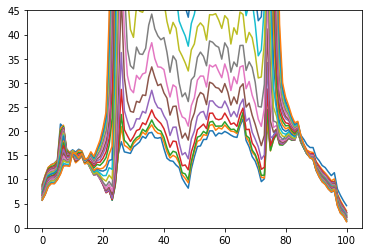

In [6]:
for i in Phase:
    plt.plot(i[50])
plt.ylim(0,45)

(0.0, 210.0)

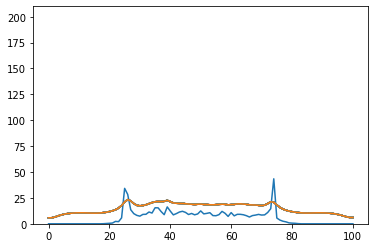

In [19]:
for i in C_time:
    plt.plot(i[50])
    
plt.ylim(0,210)

In [125]:
vals = []
for i in Phase[0]:
    for j in i:
        vals.append(j)
vals = np.array(vals)

In [147]:
num = 22.77
len(vals[vals<num])/len(vals)

0.9500061117222833

In [87]:
get_error(Phase, FC, Parameters)

(57980204.42536698, 47.27147053856498)

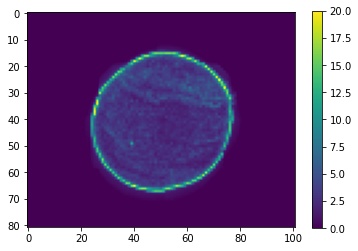

In [254]:
plt.imshow(FC[0]-1, vmin=0, vmax=20)
plt.colorbar()

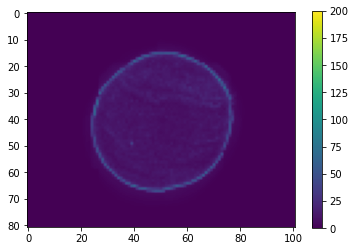

In [103]:
plt.imshow(C_time[0], vmin=0, vmax=200)
plt.colorbar()

In [59]:
## STARTING MODEL PARAMETERS and step size bounds

# Cell

log10k = 0
step_log10k = 0.1

mu = 0.35/3600        # max growth rate of strain 1 (in 1/sec)
step_mu = 0.1/3600

Rhf = 70              # cell density for half pressure (in pixel intensity)
step_Qhf = 50

Qhf = 70              # cell density for half pressure (in pixel intensity)
step_Qhf = 50

Phf = 70              # cell density for half acceptance (in pixel intensity)
step_Phf = 50

Y = 160               # biomass yield (in pixel intensity per unit S0)
step_Y = 50

# Glucose
log10Ks = -2          # rate of nutrient consumption by Monod kinetics (in unit log10S0)
step_log10Ks = 1 

# Diffusion
DC = 1200             # spreading coefficient of cells (in um^2)
step_DC = 100

DS = 200              # diffusion coefficient of glucose (in um^2/sec)
step_DS = 100

# Initial condition
S0 = 1                # glucose concentration in feed medium

in_Parameters = [log10k, mu, Rhf, Qhf, Phf, Y, log10Ks, DC, DS]
steps = [step_log10k, step_mu, step_Rhf, step_Qhf, step_Phf, step_Y, step_log10Ks, step_DC, step_DS]
idx_ex = [4] # index of parameter that need not be non-negative

In [60]:
Parameters1 = np.array([ 8.33333333e-05,  1.30000000e+02,  1.60000000e+02,  6.00000000e+01, -2.70000000e+00,  2.35000000e+03,  3.50000000e+02])

In [50]:
e1, e2 = get_error(Phase, FC, Parameters1)

In [51]:
sqrt(e1)

6250.306614577918

In [9]:
Parameters2 = np.array([ 6.94444444e-05,  7.50000000e+01,  1.50000000e+02,  1.30000000e+02, -1.70000000e+00,  1.35000000e+03,  5.00000000e+01])

In [106]:
Parameters3 = np.array([ 6.94444444e-05,  1.20000000e+02,  7.00000000e+01,  1.35000000e+02, -4.10000000e+00,  2.35000000e+03,  5.00000000e+02])

In [107]:
Parameters_min = np.array([3, 0.0000489, 291, 77, 173, 53, 0.001, 3178, 435])

In [18]:
p_vals = np.linspace(-12,-1, 20)
err1 = []
err2 = []
err3 = []
i = 0
for p in p_vals:
    Parameters[4] = p
    E1, E2 = get_error(Phase, FC, Parameters_min)
    err1.append(E1)
    err2.append(E2)
    err3.append(sqrt(E1 + lam*E2))
    i+=1
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


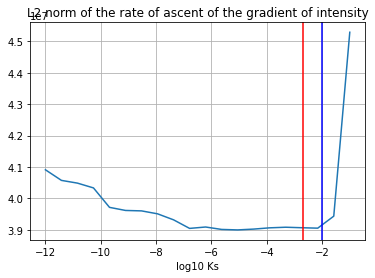

In [21]:
plt.plot(p_vals, err1)
#plt.plot(p_vals, np.sqrt(np.array(err1))/1000, '--')
plt.title('L2 norm of the rate of ascent of the gradient of intensity')
plt.xlabel('log10 Ks')
plt.axvline(Parameters1[4], color='r')
plt.axvline(in_Parameters[4], color='b')
plt.grid()

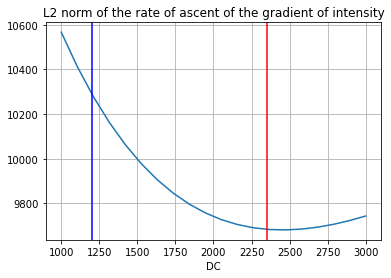

In [101]:
plt.plot(p_vals, err3)
#plt.plot(p_vals, np.sqrt(np.array(err1))/1000, '--')
plt.title('L2 norm of the rate of ascent of the gradient of intensity')
plt.xlabel('DC')
plt.axvline(Parameters3[5], color='r')
plt.axvline(in_Parameters[5], color='b')
plt.grid()

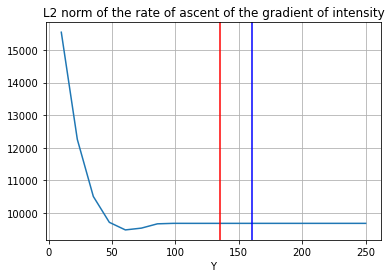

In [97]:
plt.plot(p_vals, err3)
#plt.plot(p_vals, np.sqrt(np.array(err1))/1000, '--')
plt.title('L2 norm of the rate of ascent of the gradient of intensity')
plt.xlabel('Y')
plt.axvline(Parameters3[3], color='r')
plt.axvline(in_Parameters[3], color='b')
plt.grid()

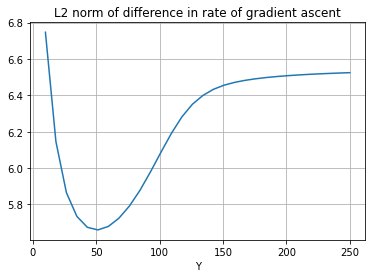

In [117]:
plt.plot(p_vals, np.sqrt(np.array(err2)))
plt.title('L2 norm of difference in rate of gradient ascent')
plt.xlabel('Y')
plt.grid()

In [103]:
l.index([1,2,3])

0

2843.0636173985135
2843.0636173985135
2626.1868059698995
2528.63002819921
2465.683174240362
2410.454032496048
2351.802472265844
2306.8309982750234
2289.114780203418
2286.425437198243
2372.2553677939495
2493.922666453222
2658.8325151828903
2883.96805531842
3258.9162682365422
3957.780125548011
5153.446089794959
5867.51252070141
4897.761984305152
4194.559904764218
3980.2456045984313
4138.372727617934


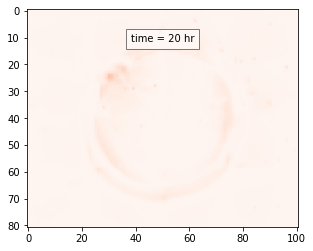

In [151]:
fig, ax = plt.subplots()
title = ax.text(0.5,0.85, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                transform=ax.transAxes, ha="center")

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []

sum = 0
def update_fig(i):
    
    sd = 0.1*Phase[i]
    sd[sd<22.7] = 22.7
    #result = sd_val.copy()
    #mask = sd_val < 1
    #sd = np.ceil(sd_val, where=mask, out=result)
    
    error = divide((C_time[i]-Phase[i])**2,sd**2)
    print(np.sum(error))
    
    im = ax.imshow(error, vmin=0, vmax=50, animated=True, cmap='Reds')
    if i == 0:
        ax.imshow(error, vmin=0, vmax=50,cmap='Reds')  # show an initial one first

    title.set_text("time = {} hr".format(i))
    #ims.append([im])

ani = animation.FuncAnimation(fig, func=update_fig, interval=300, frames = len(Phase)-1)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

HTML(ani.to_html5_video())

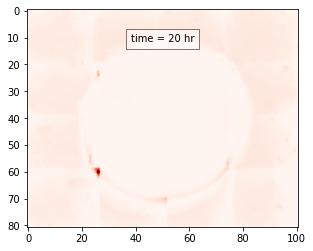

In [167]:
fig, ax = plt.subplots()
title = ax.text(0.5,0.85, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                transform=ax.transAxes, ha="center")

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
def update_fig(i):
    
    sd = 0.1*Phase[i]
    
    error = divide((C3_time[i]-Phase[i])**2,sd**2+1)
    error_new = divide((C3_time[i]-new_Phase[i])**2,sd**2+1)
    
    im = ax.imshow(error, vmin=0, vmax=1000, animated=True, cmap='Reds')
    if i == 0:
        ax.imshow(error, vmin=0, vmax=1000, cmap='Reds')  # show an initial one first

    title.set_text("time = {} hr".format(i))
    #ims.append([im])

ani = animation.FuncAnimation(fig, func=update_fig, interval=300, frames = len(Phase)-1)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

HTML(ani.to_html5_video())

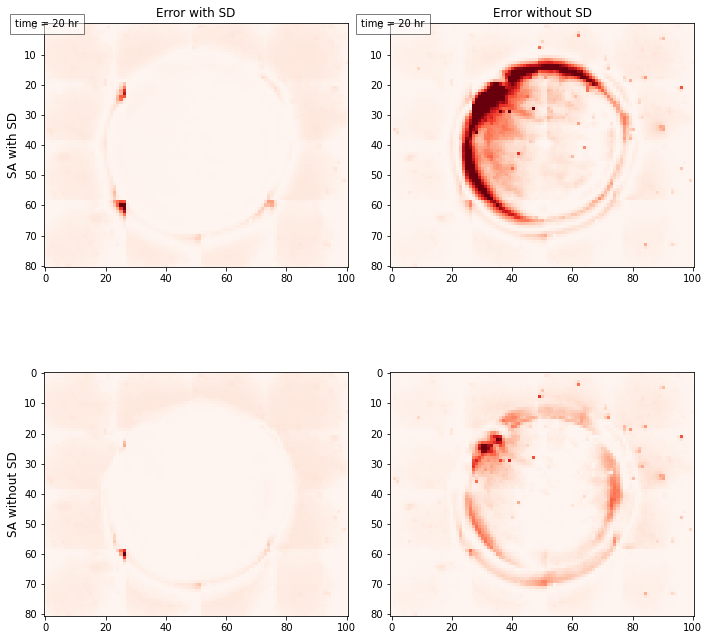

In [201]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
title1 = ax[0][0].text(0.5,.85, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},ha="center")
title2 = ax[0][1].text(0.5,0.85, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},ha="center")

cols = ['Error with SD', 'Error without SD']
rows = ['SA with SD', 'SA without SD']

for axis, col in zip(ax[0], cols):
    axis.set_title(col)

for axis, row in zip(ax[:,0], rows):
    axis.set_ylabel(row, size='large')

plt.tight_layout()
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
def update_fig(i):
    sd_val = 0.1*Phase[i]
    
    im1 = ax[0][0].imshow(divide((Cwsd_time[i]-Phase[i])**2,1+sd**2), vmin=0, vmax=1000, animated=True, cmap='Reds')
    im2 = ax[0][1].imshow((Cwsd_time[i]-Phase[i])**2, vmin=0, vmax=5000, animated=True, cmap='Reds')
    im3 = ax[1][0].imshow(divide((Cwosd_time[i]-Phase[i])**2,1+sd**2), vmin=0, vmax=1000, animated=True, cmap='Reds')
    im4 = ax[1][1].imshow((Cwosd_time[i]-Phase[i])**2, vmin=0, vmax=5000, animated=True, cmap='Reds')
    #if i==0:
    #    fig.colorbar(im1, ax=ax[0])
    #    fig.colorbar(im2, ax=ax[1])
    title1.set_text("time = {} hr".format(i))
    title2.set_text("time = {} hr".format(i))

    #ims.append([im])
    
ani = animation.FuncAnimation(fig, func=update_fig, interval=500, frames = len(Phase)-1)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

HTML(ani.to_html5_video())

In [33]:
a = [[1,2,3],[2,3,4]]

In [34]:
b = [0,9]
c = [6,5]

In [35]:
d = np.column_stack((b,c,a))

In [36]:
d

array([[0, 6, 1, 2, 3],
       [9, 5, 2, 3, 4]])

In [37]:
with open('file.txt', 'a') as file:
    file.write(f"{d[-1]} \n")

In [55]:
np.linspace(-1.5, 1.5, 31)

array([-1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5,
       -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,
        0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5])

In [4]:
var = 0
for i in Phase:
    sq = np.sum(i**2/100)
    var+=sq
print(var)

4311382.63544848


In [5]:
print(sqrt(var))

2076.386918531438


In [173]:
def get_error_wsd(Phase, FC, Parameters):
    
    k = 10**Parameters[0]
    # Initialize
    C = copy.deepcopy(FC[0])*k
    C -= threshold
    C[C<0]=0
    S = np.ones((Ly_new,Lx_new))

    # Simulate

    update_every = dthr*3600 # number of time steps after which data is stored
    C_time = []
    S_time = []

    start = time.time()

    for tt in range(T):
        if tt%update_every == 0:
            C_time.append(C.copy())
            S_time.append(S.copy())
        C, S = update(C, S, Parameters)

    stop = time.time()

    error_int = 0
    error_grad = 0

    t = time_i

    while t<time_f-2:
        xx, yy, DxO, DyO = grad_vec_field(Phase, t, Lx_new, Ly_new, dx)
        xx, yy, DxP, DyP = grad_vec_field(C_time, t, Lx_new, Ly_new, dx)
        
        sd = 0.1*Phase[t]
        
        error_int += np.sum(divide((C_time[t]-Phase[t])**2,sd**2+1))
        error_grad += np.sum((DxP-DxO)**2 + (DyP-DyO)**2)
        t+=1

    return(error_int, error_grad)

def get_error_wosd(Phase, FC, Parameters):
    
    k = 10**Parameters[0]
    # Initialize
    C = copy.deepcopy(FC[0])*k
    C -= threshold
    C[C<0]=0
    S = np.ones((Ly_new,Lx_new))

    # Simulate

    update_every = dthr*3600 # number of time steps after which data is stored
    C_time = []
    S_time = []

    start = time.time()

    for tt in range(T):
        if tt%update_every == 0:
            C_time.append(C.copy())
            S_time.append(S.copy())
        C, S = update(C, S, Parameters)

    stop = time.time()

    error_int = 0
    error_grad = 0

    t = time_i

    while t<time_f-2:
        xx, yy, DxO, DyO = grad_vec_field(Phase, t, Lx_new, Ly_new, dx)
        xx, yy, DxP, DyP = grad_vec_field(C_time, t, Lx_new, Ly_new, dx)
        
        error_int += np.sum((C_time[t]-Phase[t])**2)
        error_grad += np.sum((DxP-DxO)**2 + (DyP-DyO)**2)
        t+=1

    return(error_int, error_grad)


In [169]:
a, b = get_error(Phase, FC, in_Parameters)

In [168]:
a

6299854.152848912

In [170]:
a

6773775.487431137

In [136]:
new_Phase = []
for i in Phase:
    j = copy.deepcopy(i)
    j[abs(i-Phase[0])<10] = 0
    new_Phase.append(j)
new_Phase = np.array(new_Phase)

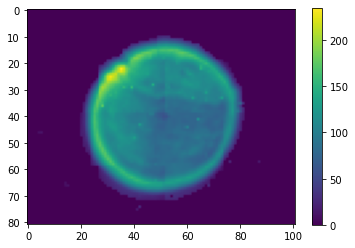

In [151]:
plt.imshow(new_Phase[16])
plt.colorbar()

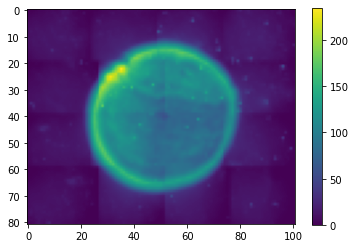

In [155]:
plt.imshow(Phase[16])
plt.colorbar()

In [120]:
a = np.array([[0.1,0.6,1],[4,0.01,0]])

In [171]:
Phase[12].shape

(81, 101)

In [195]:
Parameters_wosd = np.array([0.483, 0.0000489, 291, 77, 173, 53, -1.93, 3178, 435])
Parameters_wsd = np.array([0.245, 0.0001078, 289, 0.3, 172, 46, -0.2, 3378, 449])

In [176]:
a1wosd, b1wosd = get_error_wosd(Phase, FC, Parameters_wosd)
a2wosd, b2wosd = get_error_wosd(Phase, FC, Parameters_wsd)
a1wsd, b1wsd = get_error_wsd(Phase, FC, Parameters_wosd)
a2wsd, b2wsd = get_error_wsd(Phase, FC, Parameters_wsd)

In [177]:
print("Minimized without sd, err_wosd =", a1wosd, ", err_wsd =", a1wsd)
print("Minimized with sd, err_wosd =", a2wosd, ", err_wsd =", a2wsd)

Minimized without sd, err_wosd = 34303235.76419643 , err_wsd = 6299854.152848912
Minimized with sd, err_wosd = 40893061.01513136 , err_wsd = 5954186.105253999


In [178]:
sqrt(40893061)

6394.7682522512105

In [203]:
saop = np.loadtxt('SA_OP.txt')

In [209]:
saop

array([[ 2.45424594e-01,  1.07818375e-04,  2.89342892e+02,
         3.01217870e-01,  1.72381209e+02,  4.56737072e+01,
        -2.07864290e-01,  3.37816988e+03,  4.49344489e+02],
       [ 3.29132711e-01,  7.03387171e-05,  2.65242354e+02,
         2.71143872e-02,  1.65161249e+02,  5.11972055e+01,
        -6.73163267e-01,  3.30456699e+03,  3.87984499e+02],
       [ 4.39811901e-01,  4.27851838e-05,  2.96898810e+02,
         3.87638270e-01,  1.98554719e+02,  7.81042714e+01,
        -3.89725643e+00,  3.34362740e+03,  4.30960712e+02],
       [ 3.46043443e-01,  1.16074263e-04,  3.18335256e+02,
         5.12398763e+01,  1.81165614e+02,  6.36794116e+01,
        -1.79089800e-02,  3.43161645e+03,  4.33483254e+02],
       [ 3.32036916e-01,  1.14624302e-04,  2.64766487e+02,
         4.52788227e+01,  2.30899069e+02,  6.17559217e+01,
        -3.24461502e-02,  3.41926124e+03,  3.83360004e+02],
       [ 3.20025306e-01,  6.60717676e-05,  2.89375524e+02,
         6.97861530e-01,  1.73066271e+02,  4.283957

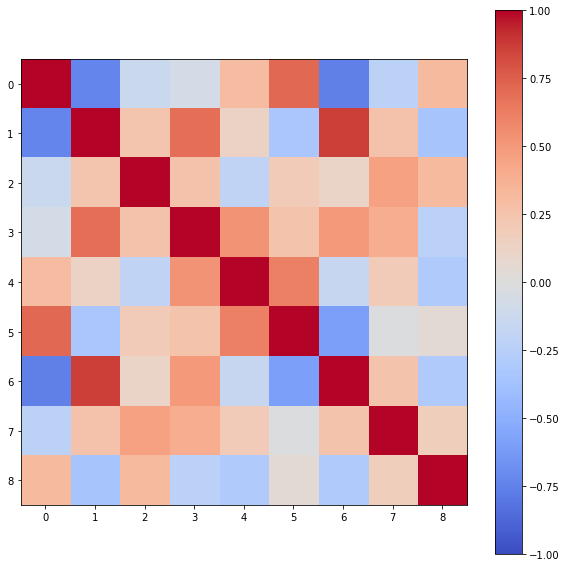

In [226]:
plt.figure(figsize=(10,10))
plt.imshow(np.corrcoef(saop.T), vmin=-1, vmax=1, cmap='coolwarm')
plt.colorbar()

In [215]:
np.max(np.cov(saop.T))

2933.511511173717

In [229]:
import csv   
fields=np.array([3,4,5])
with open('test.csv', 'a') as f:
    writer = csv.writer(f)
    writer.writerow(fields)

In [238]:
a= np.array([[0,2,0.4],[0.0001,5,7.5]])

In [239]:
result = a.copy()
mask = a < 1
np.ceil(a, where=mask, out=result)

array([[0. , 2. , 1. ],
       [1. , 5. , 7.5]])

In [266]:
10**np.random.uniform(-1,1,10)

array([1.88817799, 2.01968425, 8.17042638, 3.1312901 , 0.30858184,
       0.55709779, 0.16384095, 0.66724015, 0.20594826, 0.7559492 ])

In [5]:
sadat = np.loadtxt('SA_OP.csv', delimiter=',')
sadat = np.delete(sadat, 0, 1)

In [6]:
import pandas as pd
import seaborn as sns

In [7]:
columns = ['Error', 'k', 'mu', 'Rhf', 'Qhf', 'Phf', 'Y', 'Ks', 'DC', 'DS']
dat = pd.DataFrame(sadat, columns=columns)

<AxesSubplot:xlabel='DS', ylabel='Count'>

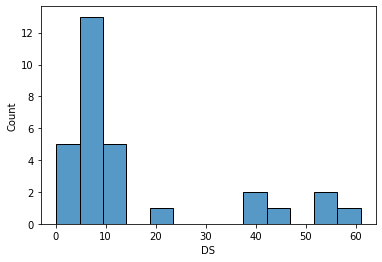

In [37]:
sns.histplot(cutdat.DS)

In [104]:
cutdat = dat[dat['Error'] < 1.5*min(sadat.T[0])]

<AxesSubplot:>

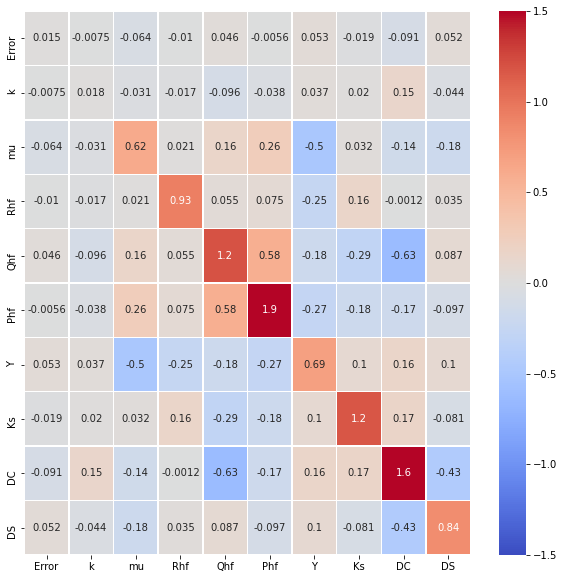

In [66]:
covmat = cutdat.cov()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(covmat, cmap ='coolwarm', vmin=-1.5, vmax=1.5, linewidths = 0.50, annot = True, ax=ax)

<AxesSubplot:>

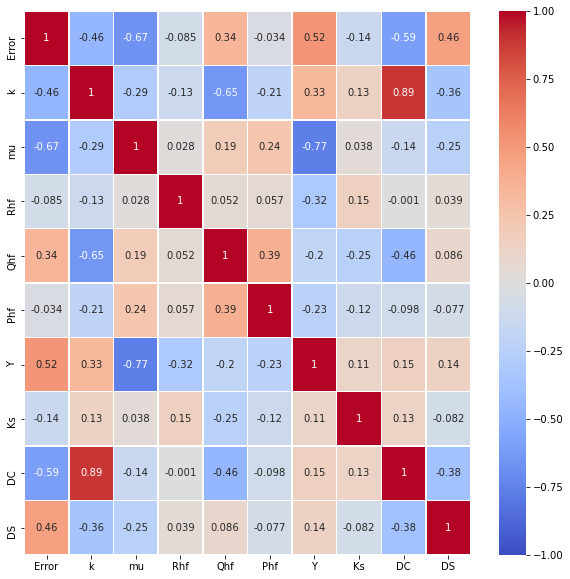

In [67]:
corrmat = cutdat.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corrmat, cmap ='coolwarm', vmin=-1, vmax=1, linewidths = 0.50, annot = True, ax=ax)

In [105]:
cutdat

,Error,k,mu,Rhf,Qhf,Phf,Y,Ks,DC,DS
0,4.603196e+06,2.785873,0.001022,1835.719129,170.415757,2724.214658,8.798031,0.000168,1.913002e+06,8.612008
1,4.734309e+06,3.253441,0.001043,38.830078,8.409569,301.180199,10.009547,0.000502,3.309354e+05,41.309420
2,4.612187e+06,3.016757,0.000965,451.022098,248.924211,8428.974072,8.512715,0.000086,3.183017e+06,8.028122
3,4.676058e+06,2.931731,0.000896,277.434304,4.886890,2484.792571,8.611280,0.081954,3.335951e+05,10.028953
4,4.761824e+06,2.654821,0.000878,3652.888500,0.697723,54101.942038,8.892855,0.212993,2.324903e+05,60.892161
...,...,...,...,...,...,...,...,...,...,...
86,4.624219e+06,3.051657,0.000920,378.902753,7.213821,26.375019,8.845167,0.001217,2.847902e+05,12.421392
87,4.730790e+06,2.887333,0.000958,6374.872694,0.624820,2354.096639,8.622298,0.003669,5.127048e+05,51.671857
88,4.604843e+06,2.851961,0.001049,124.333406,53.307375,20049.545870,9.311330,0.007729,7.804361e+05,6.564179
89,4.749877e+06,2.955416,0.001011,36.804613,0.349885,504.398226,10.445470,0.002355,4.299392e+05,41.591250


In [51]:
import random
import numpy as np
i = 0
t=0
while (i<10 and t<3):
    r = np.random.normal()
    if r<0:
        t+=1
    else:
        t=0
    i+=1
    print(i,r,t)

1 2.024748072775492 0
2 0.07189174244595575 0
3 0.42310107452509554 0
4 0.010461100305642233 0
5 1.6974307502341601 0
6 0.47868560238720387 0
7 1.6376195073013207 0
8 -0.002240241397128723 1
9 0.4100835196066751 0
10 -1.3477644441628067 1


In [4]:
""" FEB 1 MEETING PLOTS """

' FEB 1 MEETING PLOTS '

In [ ]:
Parameters_MLE = [3, 0.000993, 3024, 7.5, 1491, 9, 0.00109, 202100, 2.25]
Parameters_min = [2.7, 0.0000489, 291, 77, 173, 53, 0.001, 3178, 435]